- [R2RT - Blog](https://r2rt.com/implementing-batch-normalization-in-tensorflow.html)
- [BN Paper](https://arxiv.org/pdf/1502.03167v3.pdf)

In [1]:
%matplotlib inline
from __future__ import print_function
import numpy as np
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt

In [2]:
mnist = input_data.read_data_sets("data", one_hot=True)

Extracting data/train-images-idx3-ubyte.gz
Extracting data/train-labels-idx1-ubyte.gz
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz


[ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]
(784,)


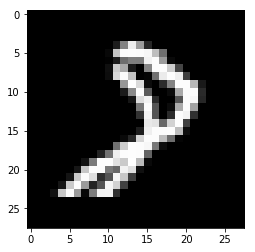

In [3]:
print(mnist.train.labels[3690])
print(mnist.train.images[3690].shape)
plt.imshow(mnist.train.images[3690].reshape((28, 28)), cmap="gray")

In [4]:
def compute_accuracy(y1, y2):
    return 100*((y1 == y2).astype(np.int).sum()/len(y1))

In [5]:
# initial values (fixed, in order to give comparable results)
np.random.seed(3690)

w1_init = np.random.randn(784, 100)
b1_init = np.random.randn(100)

w2_init = np.random.randn(100, 100)
b2_init = np.random.randn(100)

w3_init = np.random.randn(100, 10)
b3_init = np.random.randn(10)

In [6]:
# network without batch normalization
graph_no_bn = tf.Graph()

with graph_no_bn.as_default():
    tf_x_no_bn = tf.placeholder(dtype=tf.float32, 
                                shape=[None, 784])
    tf_y_no_bn = tf.placeholder(dtype=tf.float32, 
                                shape=[None, 10])
    
    # fully connected layer 1
    tf_W1_no_bn = tf.Variable(w1_init,
                              name="W1", 
                              dtype=tf.float32)
    tf_b1_no_bn = tf.Variable(b1_init,
                              name="b1",
                              dtype=tf.float32)
    tf_z1 = tf.matmul(tf_x_no_bn, tf_W1_no_bn) + tf_b1_no_bn
    tf_l1 = tf.nn.sigmoid(tf_z1)
    
    # fully connected layer 2
    tf_W2_no_bn = tf.Variable(w2_init, 
                              name="W2",
                              dtype=tf.float32)
    tf_b2_no_bn = tf.Variable(b2_init,
                              name="b2",
                              dtype=tf.float32)
    tf_z2 = tf.matmul(tf_l1, tf_W2_no_bn) + tf_b2_no_bn
    tf_l2 = tf.nn.sigmoid(tf_z2)
    
    # fully connect layer 3
    tf_W3_no_bn = tf.Variable(w3_init,
                              name="W3",
                              dtype=tf.float32)
    tf_b3_no_bn = tf.Variable(b3_init,
                              name="b3",
                              dtype=tf.float32)
    tf_l3 = tf.matmul(tf_l2, tf_W3_no_bn)+tf_b3_no_bn
    
    tf_y_hat_no_bn = tf.nn.softmax(tf_l3)
    predict_y_no_bn = tf.argmax(tf_l3, 1)
    
    cross_entropy_no_bn = -tf.reduce_sum(tf_y_no_bn*tf.log(tf_y_hat_no_bn))
    optimizer_no_bn = tf.train.GradientDescentOptimizer(learning_rate=0.01)
    train_no_nb = optimizer_no_bn.minimize(cross_entropy_no_bn)

In [7]:
batch_size=100
n_iterations = 40000

In [24]:
# SGD
loss_no_bn = [None for _ in range(n_iterations)]
accuracy_no_bn = []
with tf.Session(graph=graph_no_bn) as sess:
    tf.global_variables_initializer().run()
    for i in range(n_iterations):
        # training
        batch_images, batch_labels = mnist.train.next_batch(batch_size)
        feed_dict = {tf_x_no_bn: batch_images, tf_y_no_bn:batch_labels}
        _ = sess.run(train_no_nb, feed_dict=feed_dict)
        l = sess.run(cross_entropy_no_bn, feed_dict=feed_dict)
        loss_no_bn[i] = l
        if (i+1) % 1000 == 0:
            # prediction
            feed_dict[tf_x_no_bn] = mnist.test.images
            feed_dict[tf_y_no_bn] = mnist.test.labels
            predict_y = sess.run(predict_y_no_bn, feed_dict=feed_dict)
            acc = compute_accuracy(predict_y, np.argmax(mnist.test.labels, axis=1))
            accuracy_no_bn.append(acc)
            print("Iteration {}: {}, Test Accuracy: {}%".format(i+1, l, acc))
    train_variagles = [(v.name.split(":")[0], v.eval()) for v in tf.trainable_variables()]

Iteration 1000: 21.62377166748047, Test Accuracy: 89.95%
Iteration 2000: 15.801308631896973, Test Accuracy: 91.47%
Iteration 3000: 16.610580444335938, Test Accuracy: 93.0%
Iteration 4000: 10.222084999084473, Test Accuracy: 93.51%
Iteration 5000: 6.422296524047852, Test Accuracy: 93.77%
Iteration 6000: 3.8056282997131348, Test Accuracy: 94.06%
Iteration 7000: 4.328380584716797, Test Accuracy: 94.46%
Iteration 8000: 3.0169496536254883, Test Accuracy: 94.65%
Iteration 9000: 1.299379587173462, Test Accuracy: 94.61%
Iteration 10000: 2.874361038208008, Test Accuracy: 94.52000000000001%
Iteration 11000: 2.2626354694366455, Test Accuracy: 94.94%
Iteration 12000: 1.497992992401123, Test Accuracy: 94.87%
Iteration 13000: 1.8421605825424194, Test Accuracy: 94.84%
Iteration 14000: 2.9495558738708496, Test Accuracy: 94.77%
Iteration 15000: 2.9242286682128906, Test Accuracy: 95.15%
Iteration 16000: 0.9099052548408508, Test Accuracy: 94.67%
Iteration 17000: 1.8433599472045898, Test Accuracy: 94.89999

In [11]:
print([v[0] for v in train_variagles])
print([v[1].shape for v in train_variagles])

['W1', 'b1', 'W2', 'b2', 'W3', 'b3']
[(784, 100), (100,), (100, 100), (100,), (100, 10), (10,)]


In [12]:
print(tf.contrib.layers.batch_norm.__doc__)

Adds a Batch Normalization layer from http://arxiv.org/abs/1502.03167.

    "Batch Normalization: Accelerating Deep Network Training by Reducing
    Internal Covariate Shift"

    Sergey Ioffe, Christian Szegedy

  Can be used as a normalizer function for conv2d and fully_connected.

  Note: when training, the moving_mean and moving_variance need to be updated.
  By default the update ops are placed in `tf.GraphKeys.UPDATE_OPS`, so they
  need to be added as a dependency to the `train_op`. For example:

  ```python
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(update_ops):
      train_op = optimizer.minimize(loss)
  ```

  One can set updates_collections=None to force the updates in place, but that
  can have a speed penalty, especially in distributed settings.

  Args:
    inputs: A tensor with 2 or more dimensions, where the first dimension has
      `batch_size`. The normalization is over all but the last dimension if
      `data_format

In [28]:
# Batch Normalized (BN) Neural Network
# Here I use batch normalization layer from tf.contrib.layers.batch_norm
# but it seems like it can not reproduce the results in the blog.
# I'll try tf.nn.batch_normalization in another notebook later.
graph_bn = tf.Graph()

with graph_bn.as_default():
    tf_x_bn = tf.placeholder(dtype=tf.float32, 
                             shape=[None, 784],
                             name="tf_x_bn")
    tf_y_bn = tf.placeholder(dtype=tf.float32, 
                             shape=[None, 10],
                             name="tf_y_bn") 
    tf_is_training = tf.placeholder(tf.bool, name="is_training")
    # layer 1
    tf_W1_bn = tf.Variable(w1_init,
                           name="W1_bn",
                           dtype=tf.float32)
    tf_z1_bn = tf.matmul(tf_x_bn, tf_W1_bn)
    
    # BN for layer 1
    tf_l1 = tf.contrib.layers.batch_norm(tf_z1_bn,
                                         decay=0.999,
                                         center=True, 
                                         scale=True,
                                         epsilon=0.0001,
                                         activation_fn=tf.nn.sigmoid,
                                         is_training=tf_is_training)
    # layer 2
    tf_W2_bn = tf.Variable(w2_init,
                           name="W2_bn",
                           dtype=tf.float32)
    tf_z2_bn = tf.matmul(tf_l1, tf_W2_bn)
    # BN layer 2
    tf_l2 = tf.contrib.layers.batch_norm(tf_z2_bn,
                                         decay=0.999,
                                         center=True,
                                         scale=True,
                                         epsilon=0.0001,
                                         activation_fn=tf.nn.sigmoid,
                                         is_training=tf_is_training)
    # layer 3
    tf_W3_bn = tf.Variable(w3_init,
                           name="W3_bn",
                          dtype=tf.float32)
    tf_b3_bn = tf.Variable(b3_init,
                           name="b3_bn",
                           dtype=tf.float32)
    
    tf_z3 = tf.matmul(tf_l2, tf_W3_bn)+tf_b3_bn
    tf_l3 = tf.nn.softmax(tf_z3)
    predict_y_bn = tf.arg_max(tf_l3, 1)
    cross_entropy_bn = -tf.reduce_sum(tf_y_bn*tf.log(tf_l3))
    train_op_bn = tf.train.GradientDescentOptimizer(learning_rate=0.01).minimize(cross_entropy_bn) 

In [29]:
loss_bn = [None for _ in range(n_iterations)]
accuracy_bn = []

with tf.Session(graph=graph_bn) as sess:
    tf.global_variables_initializer().run()
    for i in range(n_iterations):
        # training
        batch_images, batch_labels = mnist.train.next_batch(batch_size)
        feed_dict = {tf_x_bn:batch_images, 
                     tf_y_bn:batch_labels,
                     tf_is_training:True}
        _ = sess.run(train_op_bn, feed_dict=feed_dict)
        l = sess.run(cross_entropy_bn, feed_dict=feed_dict)
        loss_bn[i] = l
        if (i+1) % 1000 == 0:
            # prediction
            feed_dict[tf_x_bn] = mnist.test.images
            feed_dict[tf_y_bn] = mnist.test.labels
            feed_dict[tf_is_training] = False
            predict_y = sess.run(predict_y_bn, feed_dict=feed_dict)
            acc = compute_accuracy(predict_y, np.argmax(mnist.test.labels, axis=1))
            accuracy_bn.append(acc)
            print("Iteration {}:{}, Test Accuracy:{}%".format(i+1, l, acc))

Iteration 1000:24.888896942138672, Test Accuracy:47.49%
Iteration 2000:18.471681594848633, Test Accuracy:50.55%
Iteration 3000:17.034822463989258, Test Accuracy:53.5%
Iteration 4000:13.223346710205078, Test Accuracy:52.31%
Iteration 5000:10.80402946472168, Test Accuracy:48.92%
Iteration 6000:12.952299118041992, Test Accuracy:51.61%
Iteration 7000:12.566007614135742, Test Accuracy:50.07%
Iteration 8000:5.987469673156738, Test Accuracy:51.190000000000005%
Iteration 9000:12.437122344970703, Test Accuracy:48.57%
Iteration 10000:8.325185775756836, Test Accuracy:50.4%
Iteration 11000:13.805045127868652, Test Accuracy:50.14999999999999%
Iteration 12000:2.8007874488830566, Test Accuracy:52.26%
Iteration 13000:7.077252388000488, Test Accuracy:53.21%
Iteration 14000:7.680533409118652, Test Accuracy:50.3%
Iteration 15000:6.154809474945068, Test Accuracy:51.790000000000006%
Iteration 16000:8.921774864196777, Test Accuracy:50.5%
Iteration 17000:1.9968222379684448, Test Accuracy:51.22%
Iteration 180

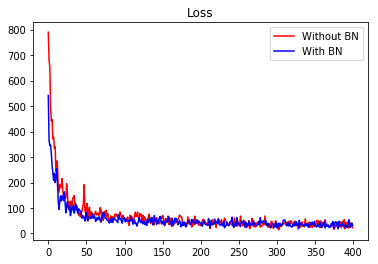

In [30]:
plt.title("Loss")
line_no_bn, = plt.plot(loss_no_bn[:400], "r-")
line_bn, = plt.plot(loss_bn[:400], "b-")
plt.legend([line_no_bn, line_bn], ["Without BN", "With BN"])

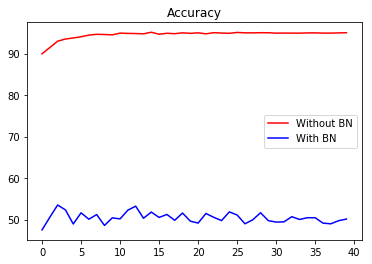

In [31]:
plt.title("Accuracy")
line_no_bn, = plt.plot(accuracy_no_bn, "r-")
line_bn, = plt.plot(accuracy_bn, "b-")
plt.legend([line_no_bn, line_bn], ["Without BN", "With BN"])